# Generator learning

In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
tqdm.monitor_interval = 0

import torch
import seaborn as sns
from matplotlib import pyplot as plt
from IPython import display as dp
from functools import partial
from torch import optim
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
sns.despine()
dp.set_matplotlib_formats('retina')

%matplotlib inline

In [2]:
from fastai.text import *

## Define model

In [3]:
PATH = '/Users/nickstulov/Desktop/Work/GenLearn/'
TRN_PATH = f'{PATH}data_sparse/'
VAL_PATH = f'{PATH}data_sparse_val/'
TST_PATH = f'{PATH}data_sparse_test/'

In [6]:
trn_files = os.listdir(TRN_PATH)
items = []
for fname in trn_files:
    if fname == '.DS_Store': continue
    df = pd.read_csv(f'{TRN_PATH}{fname}')
    df = df.drop_duplicates('t')
    df = df.drop(['t'], axis=1)
    items.append(df.values)
items = np.stack(items, axis=0)
n_samples, n_meas, n_vars = items.shape
sc = StandardScaler()
items = sc.fit_transform(items.reshape((-1, n_vars))).reshape((n_samples, n_meas, n_vars))

In [7]:
data_x, data_y = items[:, :, 2:], items[:, :, :2]
x = ItemList(data_x, label_cls=ItemList)._label_from_list(data_y, from_item_lists=True)
bunch = GenLearnDataBunch.create(train_ds=x, valid_ds=None)

In [8]:
lrn = generator_model_learner(bunch, RAWD_LSTM, loss_func=torch.nn.MSELoss())

In [9]:
lrn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05
Min loss divided by 10: 9.12E-04


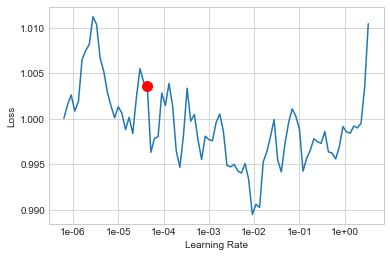

In [13]:
lrn.recorder.plot(suggestion=True)

In [14]:
lrn.fit_one_cycle(10, 5e-3, moms=(0.7,0.99), wd=0.1)

epoch,train_loss,valid_loss,time
0,0.998305,1.000101,00:06
1,0.994205,0.995600,00:05
2,0.987711,0.965062,00:05
3,0.977029,0.950377,00:05
4,0.959025,0.891293,00:04
5,0.929951,0.835880,00:04
6,0.896730,0.794811,00:06
7,0.866571,0.774904,00:06
8,0.842665,0.768855,00:06
9,0.822745,0.766748,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 8.32E-05


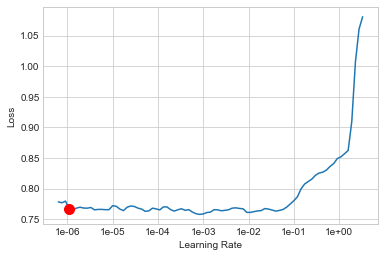

In [15]:
lrn.lr_find()
lrn.recorder.plot(suggestion=True)

In [16]:
lrn.fit_one_cycle(10, 1e-3, moms=(0.7,0.99), wd=0.1)

epoch,train_loss,valid_loss,time
0,0.764867,0.763792,00:05
1,0.766093,0.760014,00:04
2,0.761662,0.752591,00:04
3,0.756177,0.738896,00:04
4,0.750473,0.728888,00:04
5,0.745134,0.724977,00:04
6,0.738843,0.719648,00:05
7,0.734190,0.715073,00:05
8,0.728412,0.715220,00:04
9,0.723758,0.714804,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-07
Min loss divided by 10: 6.92E-08


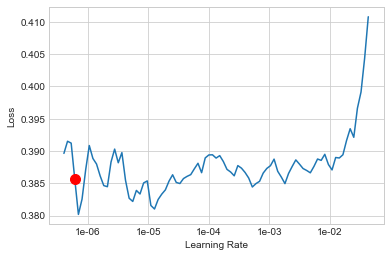

In [32]:
lrn.lr_find(end_lr=1e-1)
lrn.recorder.plot(suggestion=True)

In [33]:
lrn = lrn.clip_grad(0.3)

In [36]:
lrn.fit_one_cycle(20, 1e-5, moms=(0.7,0.99), wd=0.1)

epoch,train_loss,valid_loss,time
0,0.394727,0.373454,00:04
1,0.389965,0.373295,00:04
2,0.389744,0.373191,00:04
3,0.386333,0.373354,00:04
4,0.388729,0.372685,00:05
5,0.388520,0.372637,00:04
6,0.387034,0.372348,00:04
7,0.387788,0.372586,00:04
8,0.386860,0.372544,00:04
9,0.387169,0.372764,00:04


In [65]:
pred, true = lrn.get_preds()

In [66]:
pred = pred.numpy().transpose(1, 0, 2)
true = true.numpy().transpose(1, 0, 2)
true = np.concatenate(true, 0)
pred = np.concatenate(pred, 0)
stacked = sc.inverse_transform(np.concatenate([true, pred], -1))
pred_ = stacked[:, 2:]
stacked = sc.inverse_transform(np.concatenate([pred, true], -1))
true_ = stacked[:, 2:]

In [67]:
err = [np.sqrt(np.sum((t - p) ** 2)) / np.sqrt(np.sum(t ** 2)) \
       for t, p in zip(true_[:len(true_)//151*151].reshape((len(true_)//151, 151, 2)), 
                       pred_[:len(true_)//151*151].reshape((len(true_)//151, 151, 2)))]

In [68]:
print('\n'.join(['RMSE',
                 'mean %.4f' % np.mean(err).round(4),
                 'median %.4f' % np.median(err).round(4),
                 'max %.4f' % np.max(err).round(4),
                 'min %.4f' % np.min(err).round(4),
                 '95%% percentile %.4f' % np.percentile(err, 95).round(4)]))

RMSE
mean 0.0436
median 0.0378
max 0.1561
min 0.0238
95% percentile 0.1045


## Train

In [ ]:
learner.lr_find()

In [ ]:
learner.sched.plot(0, 0)
plt.gca().vlines(7e-4, 0.4, 1.0)

In [ ]:
learner.fit(1e-3, 10, wds=1e-6, cycle_len=1, cycle_mult=2)

In [ ]:
learner.lr_find()

In [ ]:
learner.sched.plot(0, 0)
plt.gca().vlines(1e-3, 0.4, 1.0)

In [ ]:
learner.clip = 0.3

In [ ]:
learner.fit(1e-3, 10, wds=1e-6, cycle_len=10)

## Save

In [ ]:
learner.save('model_awd.h5')

In [ ]:
learner.save_encoder('model_awd_encoder.h5')

## Load

In [ ]:
learner.load('model_awd.h5')

In [ ]:
learner.load('model_awd_with_rand.h5')

## Fine-tune for other generators

In [ ]:
learner.freeze_to(-1)

In [ ]:
learner.lr_find()

In [ ]:
learner.sched.plot(1)

In [ ]:
learner.clip = 0.5

In [ ]:
learner.fit(5e-2, 5, cycle_len=5, cycle_mult=2)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(1e-6, 10)

In [ ]:
learner.sched.plot(0)

In [ ]:
learner.clip = 10.

In [ ]:
learner.fit(5e-5, 10, cycle_len=10, cycle_mult=2)

In [ ]:
learner.clip = 0.3

In [ ]:
learner.lr_find()

In [ ]:
learner.sched.plot(0, 0)

In [ ]:
learner.fit(5e-2, 4, cycle_len=10, cycle_mult=2)

## Test

In [ ]:
pred, true = learner.predict_with_targs(True)

In [ ]:
with open('sc.pickle', 'rb') as f:
    sc = pickle.load(f)

In [ ]:
pred = pred.reshape(true.shape)
pred = pred.transpose(1, 0, 2)
true = true.transpose(1, 0, 2)
true = np.concatenate(true, 0)
pred = np.concatenate(pred, 0)
stacked = sc.inverse_transform(np.concatenate([true, pred], -1))
pred_ = stacked[:, 2:]
stacked = sc.inverse_transform(np.concatenate([pred, true], -1))
true_ = stacked[:, 2:]

In [ ]:
true_.shape

In [ ]:
pred_.shape

In [ ]:
# var_names = ['$V$', '$\\varphi$', '$P$', '$Q$']
var_names = ['$P$', '$Q$']

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(pred_[:500, i], c='r', label='pred')
    ax.plot(true_[:500, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [ ]:
err = [np.sqrt(np.sum((t - p) ** 2)) / np.sqrt(np.sum(t ** 2)) \
       for t, p in zip(true_[:len(true_)//151*151].reshape((len(true_)//151, 151, 2)), 
                       pred_[:len(true_)//151*151].reshape((len(true_)//151, 151, 2)))]

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(err)

In [ ]:
print('\n'.join(['RMSE',
                 'mean %.4f' % np.mean(err).round(4),
                 'median %.4f' % np.median(err).round(4),
                 'max %.4f' % np.max(err).round(4),
                 'min %.4f' % np.min(err).round(4),
                 '95%% percentile %.4f' % np.percentile(err, 95).round(4)]))

In [ ]:
pred, true = learner.predict_with_targs(False)

In [ ]:
pred = pred.reshape(true.shape)
pred = pred.transpose(1, 0, 2)
true = true.transpose(1, 0, 2)
true = np.concatenate(true, 0)
pred = np.concatenate(pred, 0)
stacked = sc.inverse_transform(np.concatenate([true, pred], -1))
pred_ = stacked[:, 2:]
stacked = sc.inverse_transform(np.concatenate([pred, true], -1))
true_ = stacked[:, 2:]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout(h_pad=4.0)
for i, (ax, name) in enumerate(zip(axes.flatten(), var_names)):
    ax.plot(pred_[:151, i], c='r', label='pred')
    ax.plot(true_[:151, i], c='b', label='true')
    ax.set_title(name, fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large')

In [ ]:
err = [np.sqrt(np.sum((t - p) ** 2)) / np.sqrt(np.sum(t ** 2)) \
       for t, p in zip(true_[:len(true_) // 151 * 151].reshape((len(true_) // 151, 151, 2)),
                       pred_[:len(true_) // 151 * 151].reshape((len(true_) // 151, 151, 2)))]

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(err)

In [ ]:
print('\n'.join(['RMSE',
                 'mean %.4f' % np.mean(err).round(4),
                 'median %.4f' % np.median(err).round(4),
                 'max %.4f' % np.max(err).round(4),
                 'min %.4f' % np.min(err).round(4),
                 '95%% percentile %.4f' % np.percentile(err, 95).round(4)]))